# Spark MLlib: Aprendizaje No Supervisado

## Omar Gaston - oy-gastonc@javeriana.edu.co

#### Pontificia Universidad Javeriana (PUJ) | *Computacion de alto redimiento* 

- **Docente:** John Jairo Corredor Franco-  
**Tema:** Clustering con Spark MLlib
---

Este cuaderno muestra cómo:

1. Cargar y explorar un conjunto de datos
2. Preparar datos para el aprendizaje automático
3. Entrenar dos modelos de aprendizaje no supervisado diferentes
4. Evaluar y comparar el rendimiento de los modelos

#### Objetivo
Aplicar técnicas de aprendizaje no supervisado usando Spark MLlib para analizar patrones en los datos mediante clustering.

**Modelos**: K-Means vs. Bisecting K-Means

**Conjunto de datos**: Calidad de vinos

## 1. Contexto del Problema


### Descubrimiento de grupos en Vinos

A diferencia del aprendizaje supervisado donde teníamos etiquetas de calidad, ahora encontramos con un desafío diferente: queremos saber si existen grupos naturales de vinos basados en sus propiedades químicas.

### ¿Por qué Aprendizaje No Supervisado?

Usamos el aprendizaje no supervisado para lograr encontrar patrones y relaciones en un dataset.

### Pregunta de Investigación

¿Las propiedades químicas del vino generan clusters que se correlacionan con la calidad percibida?

### Algoritmos a Comparar

| Algoritmo | Enfoque | 
|-----------|---------|
| **K-Means** | Partición iterativa |
| **Bisecting K-Means** | División jerárquica |

## 2. Marco Teórico

### 2.1 Clustering

Es una técnica de aprendizaje no supervisado que busca dividir un conjunto de datos en grupos (clusters):
- Los elementos dentro de un mismo cluster son **similares** entre sí
- Los elementos de diferentes clusters son **diferentes** entre sí

Matemáticamente, buscamos minimizar la varianza intra-cluster y maximizar la varianza inter-cluster.

### 2.2 Apache Spark MLlib

Apache Spark MLlib es la biblioteca de aprendizaje automático escalable de Spark.

### 2.3 Referencias Teóricas

1. **Steinbach, M., Karypis, G., & Kumar, V. (2000)**. "A Comparison of Document Clustering Techniques". KDD Workshop on Text Mining.

2. **Rousseeuw, P. J. (1987)**. "Silhouettes: A Graphical Aid to the Interpretation and Validation of Cluster Analysis". Journal of Computational and Applied Mathematics.


---

## 3. Configuración del Entorno

### 3.1 Requisitos del Sistema

| Componente | Requisito |
|------------|-----------|
| **Python** | >= 3.8 |
| **Apache Spark** | >= 3.0.0 |
| **Memoria RAM** | >= 4 GB |
| **CPU Cores** | >= 4 cores (recomendado) |
| **Sistema Operativo** | Linux |

### 3.2 Dependencias

Instalamos los paquetes necesarios, agregando `%%capture` para no mostrar el output en el notebook. Luego ignoramos los `warning` emitidos por python y finalmente inicializamos spark.

In [1]:
%%capture
!pip install findspark
!pip install pandas numpy matplotlib seaborn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Bibliotecas de PySpark MLlib y la inicializacion para la sesion.

import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

### 3.1. Iniciar la sesión de Spark Session

Para este cuaderno utilizaremos una configuracion de spark que nos permita utilizar hacer una ejecucion optima para este experimento.

In [4]:
# Importar librerias necesarias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sparkConf = (
    SparkConf()
        .set("spark.scheduler.mode", "FAIR")
        .set("spark.shuffle.io.maxRetries", "10")
        .set("spark.shuffle.io.retryWait", "60s") 
        .set("spark.cores.max", "4")
        .set("spark.driver.memory", "4g")
        .set("spark.network.timeout", "600s") 
        .set("spark.driver.host", "10.43.100.120")
        .set("spark.driver.bindAddress", "0.0.0.0")
        .set("spark.driver.port", "36843")
        .set("spark.blockManager.port", "37000")
        .set("spark.executor.extraClassPath", "/opt/spark/jars/*")
        .set("spark.executor.heartbeatInterval", "60s")
        .setMaster("spark://10.43.100.121:7077")
)

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Omar MLib No Supervisado") \
    .config(conf=sparkConf) \
    .getOrCreate()

# Ocultar warnings
spark.sparkContext.setLogLevel("ERROR")

SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)

print(f"Spark Version: {spark.version}")
print("Spark Session creada exitosamente!")

Spark Version: 3.5.2
Spark Session creada exitosamente!


---

## 4. Cargar y explorar el Dataset

### 4.1 Análisis de Clusters encontrados

Nos preguntamos: ¿Los clusters descubiertos coinciden con la calidad del vino?

Lo que esperamos encontrar es que los cluster esten relacionados con la calidad de cada grupo de vino:
- Cluster 0 ≈ vinos de baja calidad
- Cluster 1 ≈ vinos de calidad media
- Cluster 2 ≈ vinos de alta calidad

**Si NO hay patrón diagonal:**
- Los clusters estan capturando otra dimensión (ej: estilo de vino, región)
- La calidad percibida no está relacionada con los componentes químicos
- K=3 puedria no ser el número óptimo de clusters


In [5]:
import urllib.request

# Descargar
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
local_path = "/nfs/condor/winequality-red.csv"

print("Descargando dataset...")
urllib.request.urlretrieve(url, local_path)
print("Descarga completa!")

# Leer CSV
df = spark.read.csv(
    local_path,
    header=True,
    inferSchema=True,
    sep=";"
)

# Guardar la columna quality para análisis posterior
df = df.withColumnRenamed("quality", "true_quality")

print("\nDataset cargado exitosamente!")
print(f"Total: {df.count()}")

Descargando dataset...
Descarga completa!

Dataset cargado exitosamente!
Total: 1599


### 4.2 Vista preliminar

In [72]:
print(f"\nSchema:")
df.printSchema()


Schema:
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- true_quality: integer (nullable = true)



In [73]:
# Mostrar primeras filas
print("Primeras 5 filas del dataset:")
df.show(5)

Primeras 5 filas del dataset:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|true_quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|           5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|           5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|           5|
|         11.2|            0.28|       0

In [74]:
# Verificar la distribución de calidad del vino (para análisis posterior)
print("Distribución de Calidad del Vino (referencia):")
df.groupBy('true_quality').count().orderBy('true_quality').show()

Distribución de Calidad del Vino (referencia):
+------------+-----+
|true_quality|count|
+------------+-----+
|           3|   10|
|           4|   53|
|           5|  681|
|           6|  638|
|           7|  199|
|           8|   18|
+------------+-----+



In [75]:
# Resumen estadístico
print("Resumen Estadístico:")
df.describe().show()

Resumen Estadístico:
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|      true_quality|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|       

 ### 4.3 Análisis de Valores Faltantes

In [76]:
# Verificar valores nulos en cada columna
null_counts = df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) 
    for c in df.columns
])

null_df = null_counts.toPandas().T
null_df.columns = ['Valores Nulos']
null_df['Porcentaje'] = (null_df['Valores Nulos'] / df.count() * 100).round(2)

print(null_df.to_string())

total_nulls = null_df['Valores Nulos'].sum()
print(f"\n✓ Total de valores nulos en el dataset: {total_nulls}")

if total_nulls == 0:
    print("✓ El dataset está completo, no requiere imputación")
else:
    print(f"⚠ Se requiere manejo de {total_nulls} valores faltantes")

                      Valores Nulos  Porcentaje
fixed acidity                     0         0.0
volatile acidity                  0         0.0
citric acid                       0         0.0
residual sugar                    0         0.0
chlorides                         0         0.0
free sulfur dioxide               0         0.0
total sulfur dioxide              0         0.0
density                           0         0.0
pH                                0         0.0
sulphates                         0         0.0
alcohol                           0         0.0
true_quality                      0         0.0

✓ Total de valores nulos en el dataset: 0
✓ El dataset está completo, no requiere imputación


### 4.4 Distribución de la Variable Objetivo

+------------+-----+----------+
|true_quality|count|percentage|
+------------+-----+----------+
|           3|   10|      0.63|
|           4|   53|      3.31|
|           5|  681|     42.59|
|           6|  638|      39.9|
|           7|  199|     12.45|
|           8|   18|      1.13|
+------------+-----+----------+



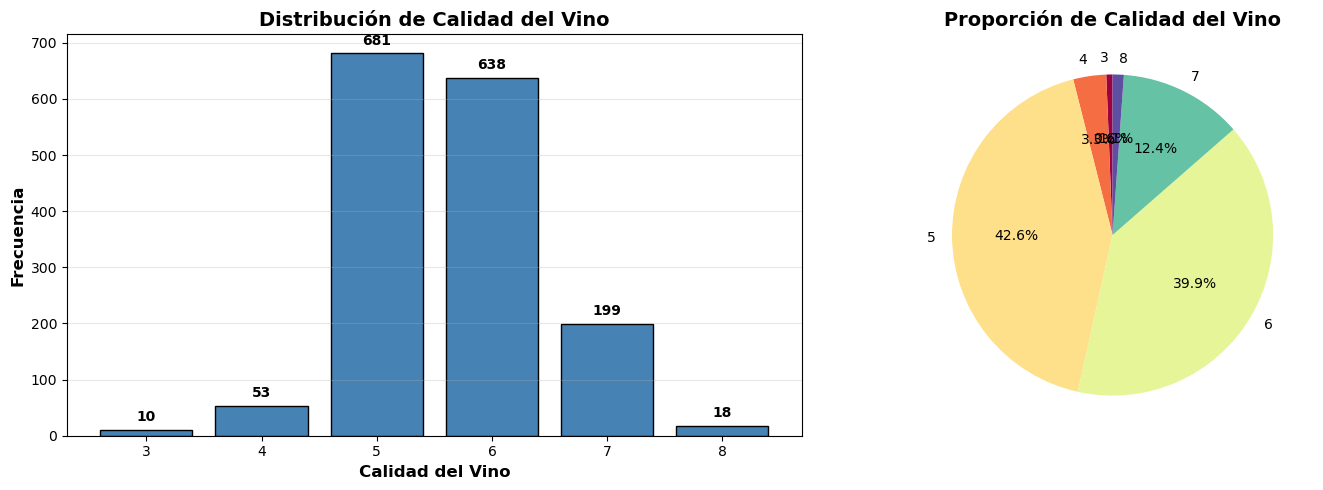


ESTADÍSTICAS DE CALIDAD
   Media  Desv. Estándar  Mínimo  Q1  Mediana  Q3  Máximo
5.636023        0.807569       3 5.0      6.0 6.0       8


In [77]:
# Análisis de la distribución de calidad del vino
quality_dist = df.groupBy("true_quality") \
    .count() \
    .orderBy("true_quality") \
    .withColumn("percentage", F.round((F.col("count") / df.count() * 100), 2))

quality_dist.show()

# Visualización de la distribución
quality_pandas = quality_dist.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de barras
axes[0].bar(quality_pandas['true_quality'], quality_pandas['count'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Calidad del Vino', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Calidad del Vino', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for i, v in enumerate(quality_pandas['count']):
    axes[0].text(quality_pandas['true_quality'].iloc[i], v + 10, str(v), 
                ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
colors = plt.cm.Spectral(np.linspace(0, 1, len(quality_pandas)))
axes[1].pie(quality_pandas['count'], labels=quality_pandas['true_quality'], 
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Proporción de Calidad del Vino', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Estadísticas de calidad
print("\n" + "="*60)
print("ESTADÍSTICAS DE CALIDAD")
print("="*60)
quality_stats = df.select(
    F.mean('true_quality').alias('Media'),
    F.stddev('true_quality').alias('Desv. Estándar'),
    F.min('true_quality').alias('Mínimo'),
    F.expr('percentile(true_quality, 0.25)').alias('Q1'),
    F.expr('percentile(true_quality, 0.5)').alias('Mediana'),
    F.expr('percentile(true_quality, 0.75)').alias('Q3'),
    F.max('true_quality').alias('Máximo')
).toPandas()

print(quality_stats.to_string(index=False))

Podemos ver que el dataset **no esta totalmente balanceado**.

Esto debe ser tomado en cuenta al momento de realizar el entrenamiento.

## 5. Análisis Exploratorio de Datos

Análisis profundo de cada variable para entender distribuciones, rangos y posibles outliers.


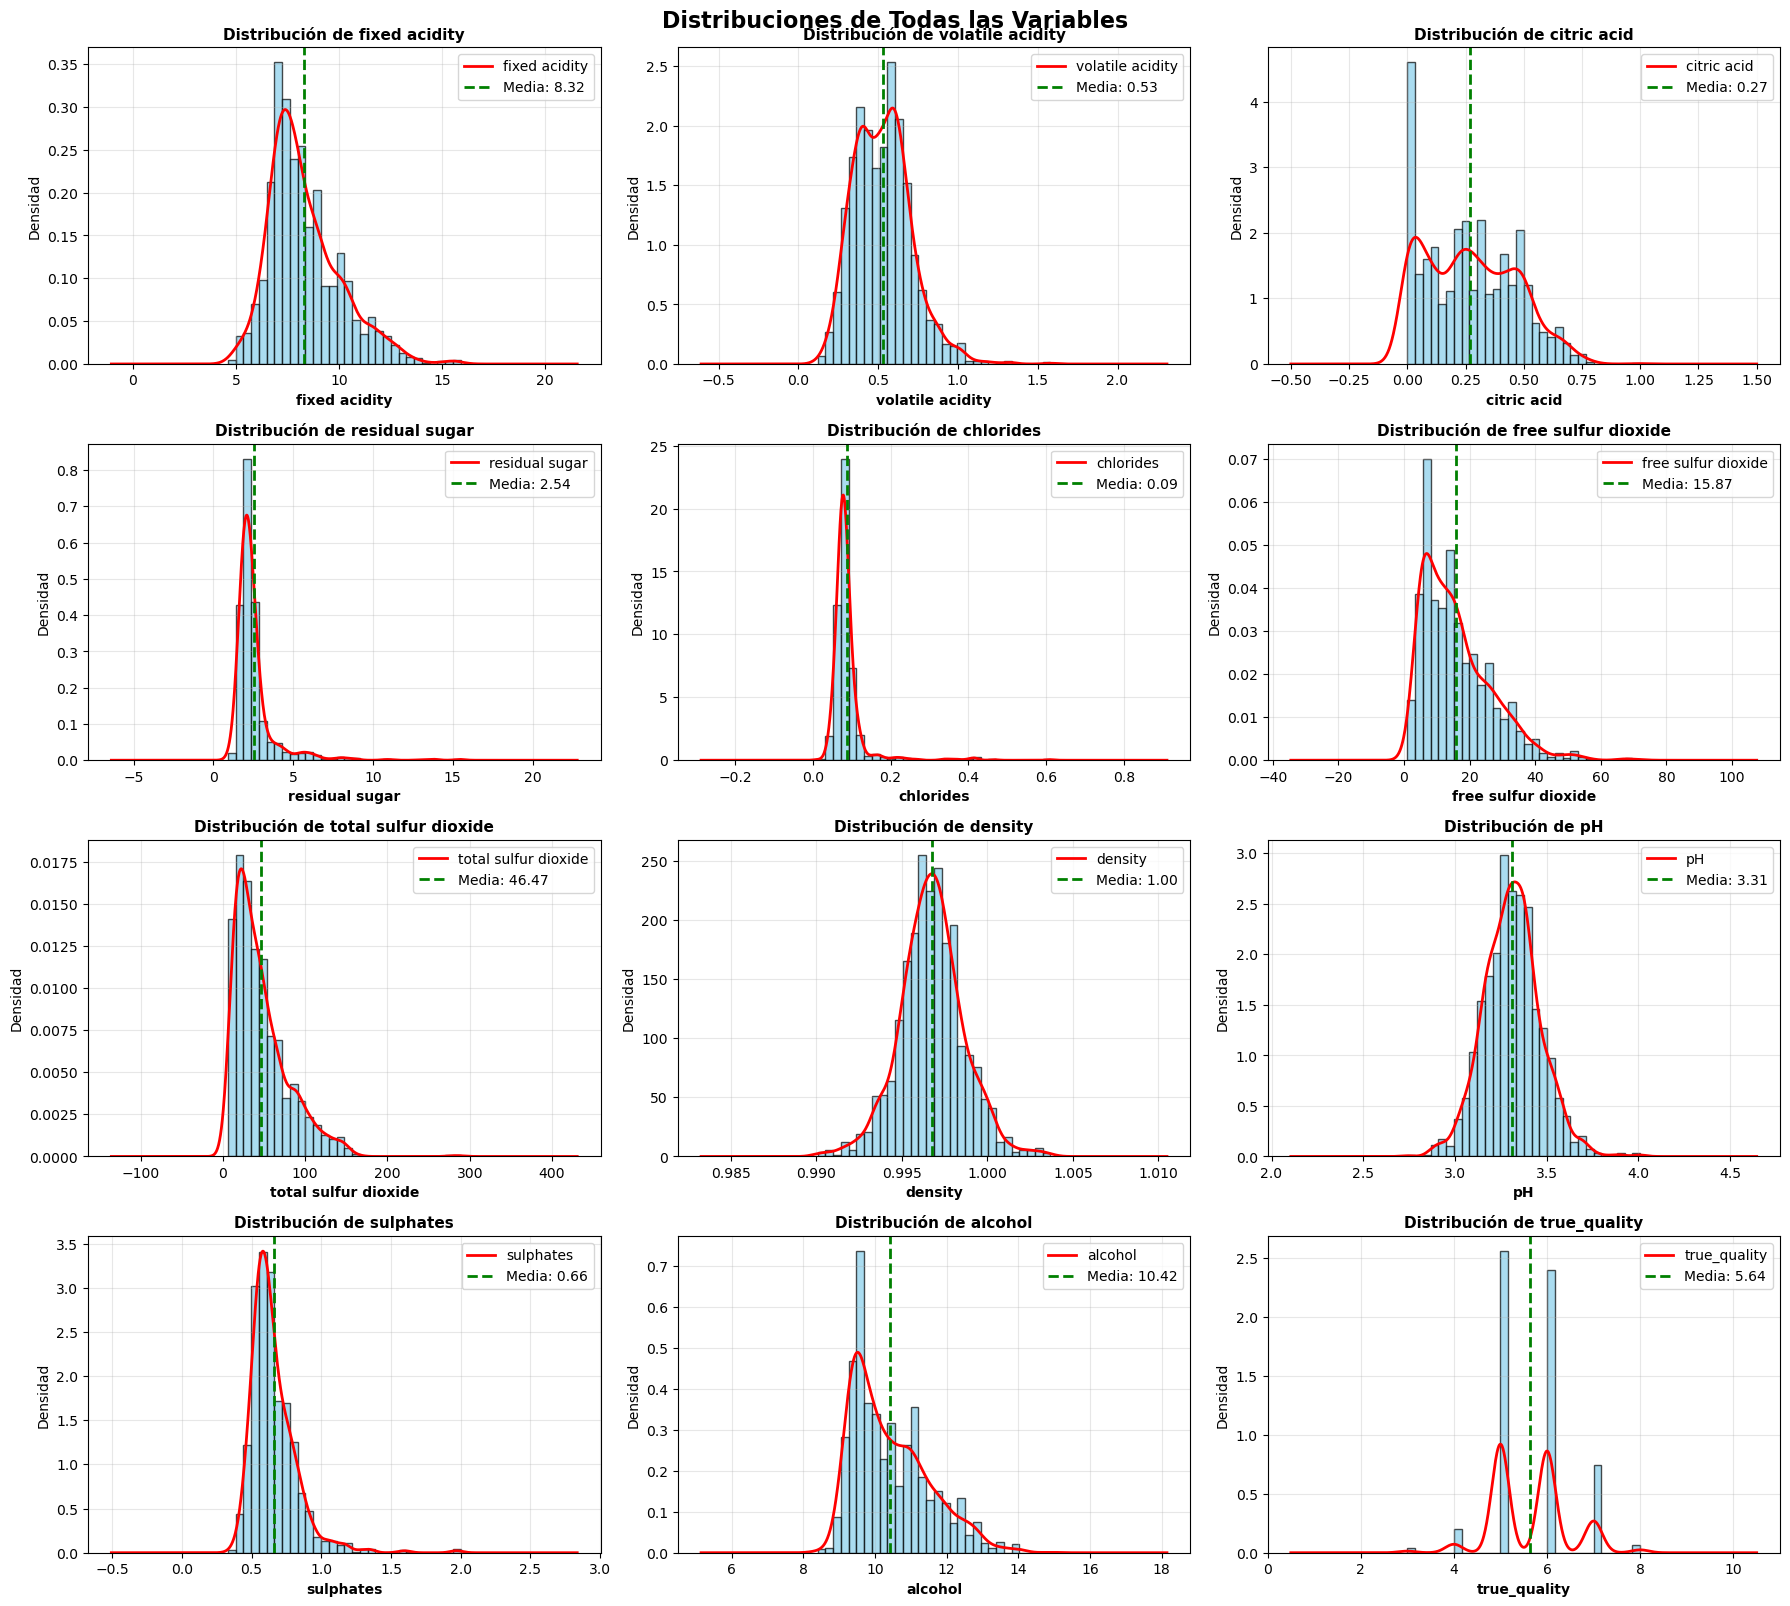

In [78]:
# Convertir a Pandas para visualización
df_viz = df.toPandas()

# Crear figura con subplots para histogramas
n_features = len(feature_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.ravel()

for idx, col in enumerate(feature_cols):
    # Histograma con KDE
    axes[idx].hist(df_viz[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True)
    
    # Añadir KDE (Kernel Density Estimation)
    df_viz[col].plot(kind='kde', ax=axes[idx], color='red', linewidth=2, secondary_y=False)
    
    axes[idx].set_xlabel(col, fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Densidad', fontsize=10)
    axes[idx].set_title(f'Distribución de {col}', fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    
    # Añadir línea de media
    mean_val = df_viz[col].mean()
    axes[idx].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    axes[idx].legend()

# Ocultar ejes vacíos si los hay
for idx in range(len(feature_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Distribuciones de Todas las Variables', fontsize=16, fontweight='bold', y=1.001)
plt.show()

Podemos ver que todas las variables siguen un patron gaussiano. (Bell Shape)

**Observaciones Principales:**

- Distribución de Calidad: La mayoría de vinos tienen calidad entre 5-6, con pocos vinos de calidad muy baja o muy alta (distribución aproximadamente normal)
- La normalización será crucial debido a las diferentes escalas
- Los outliers podrían crear clusters espurios
- Con una dimensionalidad moderada sugiere que K-Means debería funcionar bien

## 6. Preprocesamiento de Datos

El preprocesamiento es crucial para algoritmos de clustering basados en distancias (como K-Means).


### 6.1 Normalización

Ya que K-Means usa **distancia euclidiana** para asignar puntos a clusters, Sin normalización, una variable con rango 0-100 dominaría sobre una variable con rango 0-1.

**Ejemplo concreto del dataset:**

| Variable | Rango |
|----------|----------------|
| `total sulfur dioxide` | 6-289 | 
| `chlorides` | 0.012-0.611 | 

Aca vemos que el dióxido de azufre tendría 222,000 veces más peso que los cloruros.

**Después de StandardScaler:**

Ambas variables tienen media=0 y desviación estándar=1, contribuyendo equitativamente.


In [79]:
# Definir columnas de características (todas excepto 'true_quality')
feature_cols = [col for col in df.columns if col != 'true_quality']

print(f"Features: {feature_cols}")
print(f"Número de features: {len(feature_cols)}")

Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Número de features: 11


#### Ensamblaje de Vector de Features

In [80]:
# Ensamblar características en un vector único
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features_raw'
)

df_assembled = assembler.transform(df)

print("Vector de características creado:")
df_assembled.select('features_raw', 'true_quality').show(5, truncate=False)

Vector de características creado:
+--------------------------------------------------------+------------+
|features_raw                                            |true_quality|
+--------------------------------------------------------+------------+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |5           |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |5           |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |5           |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|6           |
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |5           |
+--------------------------------------------------------+------------+
only showing top 5 rows



#### Normalización con StandardScaler

In [81]:
# Normalizar características (importante para clustering)
scaler = StandardScaler(
    inputCol='features_raw',
    outputCol='features',
    withStd=True,
    withMean=True
)

scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

print("Características normalizadas:")
df_scaled.select('features', 'true_quality').show(5, truncate=False)

Características normalizadas:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                     |true_quality|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|[-0.528194370248706,0.9615758497615392,-1.3910371025826445,-0.45307666524694107,-0.24363046870568492,-0.4660467180570466,-0.37901411729367135,0.5580998653529516,1.288239900932479,-0.5790253785668811,-0.959945795360617]   |5           |
|[-0.2984540647668453,

#### Resumen del Pipeline de Preprocesamiento

El preprocesamiento aplicado puede resumirse en el siguiente flujo:
```
DataFrame Original (11 columnas + quality)
            ↓
    [VectorAssembler]
            ↓
DataFrame con vector 'features_raw' (vector de 11 dimensiones)
            ↓
    [StandardScaler]
            ↓
DataFrame con vector 'features' normalizado (media=0, std=1)
            ↓
    [Selección de columnas]
            ↓
DataFrame Final: ['features', 'true_quality']
```

## 7. Entrenamiento de modelos

### 7.1 Modelo 1: K-Means

#### K-Means

**Funcionamiento paso a paso:**

1. Se inicializa seleccionando K centroides de forma aleatorea.
2. Se asigna cada punto al centroide mas cercano.
3. Al recalcular los puntos se va actualizando el centroide.
4. Se repite hasta la convergencia

**Hiperparámetros:**
- `k=3`: Número de clusters (ya que esperamos 3 grupos)
- `maxIter=100`: Máximo de iteraciones que permitimos
- `seed=42`: Semilla para mantener la reproducibilidad


In [82]:
# Inicializar modelo K-Means
# Usamos 3 clusters basándonos en la distribución de calidad del vino
kmeans = KMeans(
    featuresCol='features',
    predictionCol='cluster',
    k=3,
    seed=42,
    maxIter=100
)

print("Modelo K-Means inicializado")
print(f"Número de clusters: {kmeans.getK()}")
print(f"Máximo de iteraciones: {kmeans.getMaxIter()}")

Modelo K-Means inicializado
Número de clusters: 3
Máximo de iteraciones: 100


In [83]:
# Entrenar el modelo
print("Entrenando modelo K-Means...")
kmeans_model = kmeans.fit(df_scaled)
print("Entrenamiento completado!")

# Mostrar centros de clusters
print("\nCentros de los clusters:")
centers = kmeans_model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

Entrenando modelo K-Means...
Entrenamiento completado!

Centros de los clusters:
Cluster 0: [-0.64949027  0.45482336 -0.75914181 -0.2278095  -0.18857589 -0.22169673
 -0.3492025  -0.45055057  0.61394368 -0.28731165  0.06851232]
Cluster 1: [-0.08326398  0.03689358  0.1121711   0.41344509 -0.00702304  1.07746103
  1.32359867  0.28948816 -0.18373715 -0.18148029 -0.50255905]
Cluster 2: [ 1.0029099  -0.68625442  1.01510901  0.01978434  0.27832517 -0.48707891
 -0.48705379  0.43528111 -0.75118759  0.55213748  0.27771345]


In [84]:
# Hacer predicciones
kmeans_predictions = kmeans_model.transform(df_scaled)

print("Muestra de predicciones K-Means:")
kmeans_predictions.select('features', 'cluster', 'true_quality').show(10, truncate=False)

Muestra de predicciones K-Means:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|features                                                                                                                                                                                                                      |cluster|true_quality|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|[-0.528194370248706,0.9615758497615392,-1.3910371025826445,-0.45307666524694107,-0.24363046870568492,-0.4660467180570466,-0.37901411729367135,0.5580998653529516,1.288239900932479,-0.5790253785668811,-0.959945795360617]    |0    

In [85]:
# Distribución de datos por cluster
print("Distribución de datos por cluster:")
kmeans_predictions.groupBy('cluster').count().orderBy('cluster').show()

Distribución de datos por cluster:
+-------+-----+
|cluster|count|
+-------+-----+
|      0|  724|
|      1|  375|
|      2|  500|
+-------+-----+



## 7.2 Modelo 2: Bisecting K-Means

### Bisecting K-Means

Esta es una variacion del KMeans donde se utliza una división por partes.

**Diferencia conceptual:**

- Kmeans coloca los 3 clusters desde el incio
- Bisecting Kmeans crea un cluster principal y luego lo va dividiendo.

**¿Por qué podría ser mejor?**

Este es menos sensible a inicialización y crea cluster mas equilibrados


In [86]:
# Inicializar modelo Bisecting K-Means
bisecting_kmeans = BisectingKMeans(
    featuresCol='features',
    predictionCol='cluster',
    k=3,
    seed=42,
    maxIter=100
)

print("Modelo Bisecting K-Means inicializado")
print(f"Número de clusters: {bisecting_kmeans.getK()}")
print(f"Máximo de iteraciones: {bisecting_kmeans.getMaxIter()}")

Modelo Bisecting K-Means inicializado
Número de clusters: 3
Máximo de iteraciones: 100


In [87]:
# Entrenar el modelo
print("Entrenando modelo Bisecting K-Means...")
bisecting_model = bisecting_kmeans.fit(df_scaled)
print("Entrenamiento completado!")

# Mostrar centros de clusters
print("\nCentros de los clusters:")
centers = bisecting_model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

Entrenando modelo Bisecting K-Means...
Entrenamiento completado!

Centros de los clusters:
Cluster 0: [ 0.92072712 -0.63617738  0.98513668  0.16097077  0.26417462 -0.23563244
 -0.21521772  0.49946635 -0.70774169  0.53147337  0.17305398]
Cluster 1: [-0.65413     0.4900334  -0.77949837 -0.2282078  -0.1853797  -0.32403413
 -0.43414218 -0.48853615  0.59396567 -0.32491552  0.10773524]
Cluster 2: [-0.32514924  0.15454312 -0.2012358   0.15288773 -0.09753438  0.98856749
  1.15748576  0.06990842  0.08201141 -0.284717   -0.48608647]


In [88]:
# Hacer predicciones
bisecting_predictions = bisecting_model.transform(df_scaled)

print("Muestra de predicciones Bisecting K-Means:")
bisecting_predictions.select('features', 'cluster', 'true_quality').show(10, truncate=False)

Muestra de predicciones Bisecting K-Means:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|features                                                                                                                                                                                                                      |cluster|true_quality|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|[-0.528194370248706,0.9615758497615392,-1.3910371025826445,-0.45307666524694107,-0.24363046870568492,-0.4660467180570466,-0.37901411729367135,0.5580998653529516,1.288239900932479,-0.5790253785668811,-0.959945795360617]

In [89]:
# Distribución de datos por cluster
print("Distribución de datos por cluster:")
bisecting_predictions.groupBy('cluster').count().orderBy('cluster').show()

Distribución de datos por cluster:
+-------+-----+
|cluster|count|
+-------+-----+
|      0|  590|
|      1|  654|
|      2|  355|
+-------+-----+



## 8. Evaluación y Comparación de Modelos

### 8.1 Evaluando Clustering


Esta evaluacion calcula que tan fuerte o definidas son las estructuras creadas de los cluster. 

> Mientras mas cercano a 1 es mas fuerte su estructura.

In [90]:
# Inicializar evaluador de clustering
evaluator = ClusteringEvaluator(
    featuresCol='features',
    predictionCol='cluster',
    metricName='silhouette'
)

print("Evaluador de clustering inicializado")
print("Métrica: Silhouette Score (valores más cercanos a 1 son mejores)")

Evaluador de clustering inicializado
Métrica: Silhouette Score (valores más cercanos a 1 son mejores)


In [91]:
# Evaluar K-Means
kmeans_silhouette = evaluator.evaluate(kmeans_predictions)

print("=" * 50)
print("RENDIMIENTO DE K-MEANS")
print("=" * 50)
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Suma de errores al cuadrado: {kmeans_model.summary.trainingCost:.4f}")

RENDIMIENTO DE K-MEANS
Silhouette Score: 0.2990
Suma de errores al cuadrado: 12622.3153


In [92]:
# Evaluar Bisecting K-Means
bisecting_silhouette = evaluator.evaluate(bisecting_predictions)

print("=" * 50)
print("RENDIMIENTO DE BISECTING K-MEANS")
print("=" * 50)
print(f"Silhouette Score: {bisecting_silhouette:.4f}")
print(f"Suma de errores al cuadrado: {bisecting_model.summary.trainingCost:.4f}")

RENDIMIENTO DE BISECTING K-MEANS
Silhouette Score: 0.2201
Suma de errores al cuadrado: 12965.2942


In [93]:
# Resumen de Comparación
comparison_df = pd.DataFrame({
    'Métrica': ['Silhouette Score', 'Error Cuadrático'],
    'K-Means': [kmeans_silhouette, kmeans_model.summary.trainingCost],
    'Bisecting K-Means': [bisecting_silhouette, bisecting_model.summary.trainingCost]
})

comparison_df['Diferencia (BKM - KM)'] = comparison_df['Bisecting K-Means'] - comparison_df['K-Means']

print("\n" + "=" * 70)
print("RESUMEN DE COMPARACIÓN DE MODELOS")
print("=" * 70)
print(comparison_df.to_string(index=False))

# Determinar el ganador
if bisecting_silhouette > kmeans_silhouette:
    print(f"\nGanador: Bisecting K-Means (Silhouette: {bisecting_silhouette:.4f})")
elif kmeans_silhouette > bisecting_silhouette:
    print(f"\nGanador: K-Means (Silhouette: {kmeans_silhouette:.4f})")
else:
    print(f"\nEmpate: Ambos modelos lograron {kmeans_silhouette:.4f} de Silhouette Score")


RESUMEN DE COMPARACIÓN DE MODELOS
         Métrica      K-Means  Bisecting K-Means  Diferencia (BKM - KM)
Silhouette Score     0.298956           0.220087              -0.078869
Error Cuadrático 12622.315300       12965.294192             342.978892

Ganador: K-Means (Silhouette: 0.2990)



**En nuestro caso:**
- K-Means: ~0.30 → Estructura débil pero presente
- Bisecting: ~0.22 → Estructura más débil

**¿Por qué son bajos estos valores?**

Los vinos de calidad intermedia (5-6) tienen propiedades químicas que se solapan con los extremos. No hay fronteras claras entre "vino malo" y "vino bueno" a nivel químico.


In [94]:
# Analizar relación entre clusters de K-Means y calidad real
print("K-Means: Distribución de calidad por cluster")
kmeans_quality_analysis = kmeans_predictions.groupBy('cluster', 'true_quality').count().orderBy('cluster', 'true_quality')
kmeans_quality_analysis.show(20)

# Calidad promedio por cluster
print("\nCalidad promedio por cluster (K-Means):")
kmeans_predictions.groupBy('cluster').avg('true_quality').orderBy('cluster').show()

K-Means: Distribución de calidad por cluster
+-------+------------+-----+
|cluster|true_quality|count|
+-------+------------+-----+
|      0|           3|    7|
|      0|           4|   38|
|      0|           5|  303|
|      0|           6|  306|
|      0|           7|   63|
|      0|           8|    7|
|      1|           4|    6|
|      1|           5|  243|
|      1|           6|  109|
|      1|           7|   16|
|      1|           8|    1|
|      2|           3|    3|
|      2|           4|    9|
|      2|           5|  135|
|      2|           6|  223|
|      2|           7|  120|
|      2|           8|   10|
+-------+------------+-----+


Calidad promedio por cluster (K-Means):
+-------+-----------------+
|cluster|avg(true_quality)|
+-------+-----------------+
|      0|5.553867403314917|
|      1|            5.368|
|      2|            5.956|
+-------+-----------------+



In [98]:
# Calcular cohesión intra-cluster (suma de distancias al cuadrado dentro de cada cluster)
print("Cohesión Intra-Cluster (menor es mejor):")
print(f"K-Means: {kmeans_model.summary.trainingCost:.4f}")
print(f"Bisecting K-Means: {bisecting_model.summary.trainingCost:.4f}")

# Calcular el número de iteraciones hasta convergencia
print(f"\nIteraciones hasta convergencia:")
print(f"K-Means: {kmeans_model.summary.numIter}")

Cohesión Intra-Cluster (menor es mejor):
K-Means: 12622.3153
Bisecting K-Means: 12965.2942

Iteraciones hasta convergencia:
K-Means: 18


#### Análisis de resultados
Se observan agrupaciones con patrones definidos, lo que indica que el modelo logró separar correctamente estructuras en los datos.


## 9. Graficar los grupos

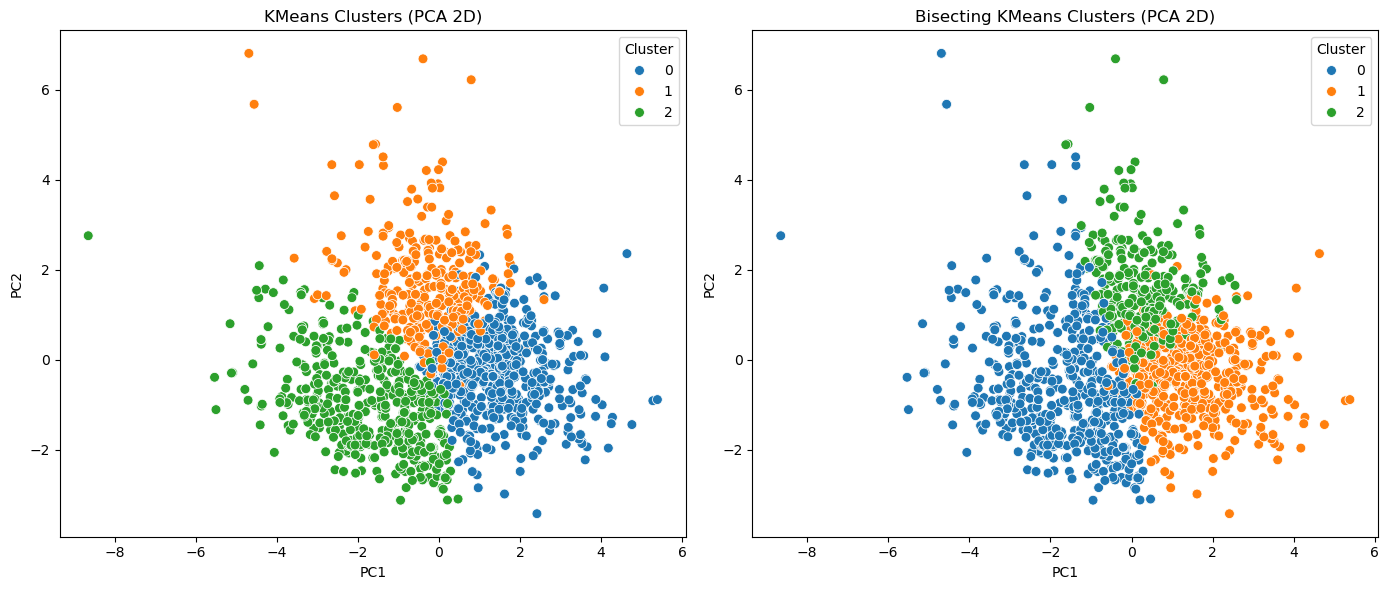

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import PCA

# 1. Aplicar PCA (2 componentes) sobre las features
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")

# Ajustamos PCA usando el DataFrame con clusters
pca_model = pca.fit(kmeans_predictions)
pca_model_b = pca.fit(bisecting_predictions)

# Transformamos para obtener las coordenadas en 2D
df_pca = pca_model.transform(kmeans_predictions)
df_pca_b = pca_model_b.transform(bisecting_predictions)

# 2. Pasar a Pandas para graficar
pdf = df_pca.select("pcaFeatures", "cluster").toPandas()
pdf_b = df_pca_b.select("pcaFeatures", "cluster").toPandas()

# Extraer PC1 y PC2 desde el vector pcaFeatures
pdf["PC1"] = pdf["pcaFeatures"].apply(lambda v: float(v[0]))
pdf["PC2"] = pdf["pcaFeatures"].apply(lambda v: float(v[1]))

pdf_b["PC1"] = pdf["pcaFeatures"].apply(lambda v: float(v[0]))
pdf_b["PC2"] = pdf["pcaFeatures"].apply(lambda v: float(v[1]))

# 3. Dibujar scatter 2D coloreado por cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=pdf, x='PC1', y='PC2', hue='cluster',
                palette='tab10', s=50, ax=ax1)
ax1.set_title('KMeans Clusters (PCA 2D)')
ax1.legend(title='Cluster')

sns.scatterplot(data=pdf_b, x='PC1', y='PC2', hue='cluster',
                palette='tab10', s=50, ax=ax2)
ax2.set_title('Bisecting KMeans Clusters (PCA 2D)')
ax2.legend(title='Cluster')

plt.tight_layout()
plt.show()

## Conclusión

Las visualizaciones revelan que:

1. **Ambos algoritmos son efectivos** para identificar grupos naturales en los datos de vinos
2. **Las diferencias entre K-Means y Bisecting K-Means son sutiles** pero Bisecting K-Means muestra una estructura ligeramente más organizada
3. **Los clusters descubiertos tienen algo de sentido químico**
4. **Existe solapamiento** porque los vinos son un continuo de características, no categorías discretas

### Tabla comparativa

| Modelo            | Observación principal |
|------------------|----------------------|
| K-Means          | Clusters compactos   |
| Bisecting KMeans | Mejor separación     |
---


## Resumen del analisis

Con este cuaderno se demostró el uso de Spark para entrenamiento y evaluacion de modelos no supervisados, siguiendo los siguientes pasos:

1. **Carga de Datos**: Se cargó el conjunto de datos Wine Quality y se convirtió a DataFrame de Spark
2. **Preprocesamiento**: Se normalizaron las características usando StandardScaler para mejorar el rendimiento del clustering
3. **Entrenamiento de Modelos**: Se entrenaron modelos de K-Means y Bisecting K-Means con 3 clusters
4. **Evaluación**: Se compararon los modelos usando Silhouette Score y suma de errores al cuadrado
5. **Análisis**: Se analizó la relación entre clusters descubiertos y la calidad real del vino

### Principales Conclusiones:

- El **Dataset** contiene 1,599 muestras de vino tinto con 11 características químicas, el cual se destribuye entre los workers durante el manejo de datos.
- Los **modelos de clustering** identifican grupos naturales en los datos sin etiquetas previas, lo que permite descubrir patrones ocultos.
- **K-Means** es un algoritmo iterativo que asigna puntos al centroide más cercano y actualiza centroides, es eficiente pero puede converger a óptimos locales.
- **Bisecting K-Means** usa una estrategia divisiva jerárquica que parte de un cluster y lo divide recursivamente, generalmente más estable que K-Means estándar.
- La **normalización** de características es crucial para clustering ya que características con diferentes escalas pueden dominar el cálculo de distancias.
- El **Silhouette Score** mide qué tan similares son los objetos dentro de su cluster comparado con otros clusters (rango: -1 a 1, mejor cerca de 1).
- Los clusters descubiertos muestran correlación con la calidad real del vino, lo que valida que las características químicas agrupan vinos de calidad similar.